In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from mindquantum.core.circuit import Circuit,shift, UN
from mindquantum.core.gates import H,X,Y,Z, RX, RY, RZ,Measure
from mindquantum.core.operators import Hamiltonian,TimeEvolution, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import inner_product, Simulator
from mindquantum.algorithm.nisq import HardwareEfficientAnsatz
from mindspore.common.parameter import Parameter

import networkx as nx
import mindspore.nn as nn
import mindspore as ms
import matplotlib.pyplot as plt
import numpy as np  
import random
import itertools
import pandas as pd

print('Modules imported successfully!')

Modules imported successfully!


# The graph to be solved. Each code only solves one of the following graphs

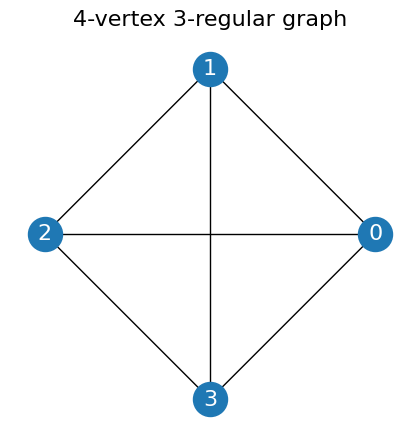

In [2]:
# Construction the solved graph
G = nx.Graph()
G.add_edges_from([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)])
qubit_num = len(G.nodes)

plt.figure(figsize=(4, 4))              # Set the figure canvas size
pos = nx.circular_layout(G)    
nx.draw(G,pos, with_labels=True, alpha=1.0, node_size=600, font_size=16, font_color="white", width=1)
plt.title("4-vertex 3-regular graph", fontsize=16)
plt.show()

# Output all possible dominating sets and their numbers

It uses a classic exhaustive algorithm and can only be used for small-scale graph instances.

In [3]:
def is_dominating_set(graph, vertex_set):
    """
    Determines whether the given vertex set is a dominating set.
    
    Args:
        vertex_set (set or list): A set of vertices to check.
    
    Returns:
        bool: True if vertex_set is a dominating set; otherwise False.
    """
    dominated = set(vertex_set)
    for v in vertex_set:
        dominated.update(graph.neighbors(v))  # Add neighbors of v
    
    return dominated == set(graph.nodes())

def find_all_dominating_sets(graph):
    """
    Enumerate all possible dominating sets.
    
    Returns:
        list[set]: A list of all dominating sets.
    """
    all_dominating_sets = []
    n = len(graph.nodes())
    
    for r in range(1, n + 1):  # Try all possible subset sizes
        for subset in itertools.combinations(graph.nodes(), r):
            if is_dominating_set(graph, subset):
                all_dominating_sets.append(set(subset))
    return all_dominating_sets

def find_minimum_dominating_sets(graph):
    """
    Find all minimum dominating sets (smallest size).
    
    Returns:
        list[set]: A list of minimum dominating sets.
    """
    all_dominating_sets = find_all_dominating_sets(graph)
    min_size = min(len(ds) for ds in all_dominating_sets)
    minimum_dominating_sets = [ds for ds in all_dominating_sets if len(ds) == min_size]
    return minimum_dominating_sets

# Get all possible minimum dominating sets
minimum_dominating_sets = find_minimum_dominating_sets(G)

print(f"The number of minimum dominating sets: {len(minimum_dominating_sets)}")
print("All possible minimum dominating sets:")
for mds in minimum_dominating_sets:
    print(mds)

The number of minimum dominating sets: 4
All possible minimum dominating sets:
{0}
{1}
{2}
{3}


# Construct the corresponding problem Hamiltonian Hp

In [4]:
import networkx as nx
from sympy import symbols, expand, simplify

def construct_mds_hamiltonian(graph):
    """
    parameter：
        graph (networkx.Graph): Input undirected graph.
        penalty_coef (float): The coefficient of the penalty term.

    return：
        sympy.Expr: A symbolic expression representing the Hamiltonian.
    """
    # define variables
    x_vars = symbols(f'x0:{len(G.nodes())}')
    z_vars = symbols(f'Z0:{len(G.nodes())}')
    
    
    # Construct a substitution relationship between x_i and Z_i
    substitutions = {x: (1 - z)/2 for x, z in zip(x_vars, z_vars)}

    # Constructing the objective function: maximize
    fun = sum(x_vars)
    obj_fun = len(G.nodes()) - fun 
    
    # Constructing the penalty term of the constraint
    penalty_terms = []
    for i, x_i in enumerate(x_vars):
        neighbors = list(G.neighbors(i))
        neighbor_vars = [x_vars[j] for j in neighbors]
        
        # Compute the dominated case: 1-(1 - x_i) * ∏(1 - x_j)
        term = (1 - x_i)
        for x_j in neighbor_vars:
            term *= (1 - x_j)
            
        penalty_terms.append(1 - term)
        
    penalty = sum(penalty_terms)
    
    # Construct the objective function to be minimized
    objective = -obj_fun - penalty

    # Replace x_i with the expression of Z_i
    hamiltonian = objective.subs(substitutions)

    # Expand and simplify expressions
    mds_hamiltonian = simplify(expand(hamiltonian))

    return mds_hamiltonian


# Constructing the problem Hamiltonian
mds_hamiltonian = construct_mds_hamiltonian(G)   

# Output
print("The constructed Hamiltonian is：")
print(mds_hamiltonian)

The constructed Hamiltonian is：
Z0*Z1*Z2*Z3/4 + Z0*Z1*Z2/4 + Z0*Z1*Z3/4 + Z0*Z1/4 + Z0*Z2*Z3/4 + Z0*Z2/4 + Z0*Z3/4 - Z0/4 + Z1*Z2*Z3/4 + Z1*Z2/4 + Z1*Z3/4 - Z1/4 + Z2*Z3/4 - Z2/4 - Z3/4 - 23/4


# Resolve mds_hamiltonian into a QubitOperator.

In [5]:
import re
import sympy
from sympy import sympify, Rational


def parse_hamiltonian(expr_str):
    """
    Parsing Pauli string expressions as QubitOperators
    """
    # Extract Pauli terms 
    pauli_tokens = set(re.findall(r'([XYZ]\d+)', expr_str))
    locals_dict = {tok: sympy.Symbol(tok) for tok in pauli_tokens}

    # Parsing Expressions
    expr = sympify(expr_str, locals=locals_dict)

    QuOperator = QubitOperator()

    for term in expr.as_ordered_terms():
        coeff, rest = term.as_coeff_Mul()

        # Extract Pauli terms
        if isinstance(rest, sympy.Symbol):
            syms = [str(rest)]
        elif rest == 1:
            syms = []
        else:
            syms = [str(f) for f in rest.args if isinstance(f, sympy.Symbol)]

        syms_sorted = sorted(syms, key=lambda s: int(s[1:]))
        pauli_str = ' '.join(syms_sorted)

        # Use fractional form to express coefficients
        coeff_frac = Rational(str(coeff))  
        QuOperator += QubitOperator(pauli_str, float(coeff_frac))

    return QuOperator


H_C = parse_hamiltonian(str(mds_hamiltonian))
print(H_C)

  1/4 [Z0 Z1 Z2 Z3] +
  1/4 [Z0 Z1 Z2] +
  1/4 [Z0 Z1 Z3] +
  1/4 [Z0 Z1] +
  1/4 [Z0 Z2 Z3] +
  1/4 [Z0 Z2] +
  1/4 [Z0 Z3] +
 -1/4 [Z0] +
  1/4 [Z1 Z2 Z3] +
  1/4 [Z1 Z2] +
  1/4 [Z1 Z3] +
 -1/4 [Z1] +
  1/4 [Z2 Z3] +
 -1/4 [Z2] +
 -1/4 [Z3] +
-5.75 []


# Build the quantum circuit of D_{i}(x)

According to Guerrero's QAOA method, the MDS problem is solved by maximizing the cost fucntion C(x)=sum_{i=1}^{n-1} (D_{i}(x) + T_{i}(x)). Firtstly, we build the quantum circuit for D_{i}(x). 

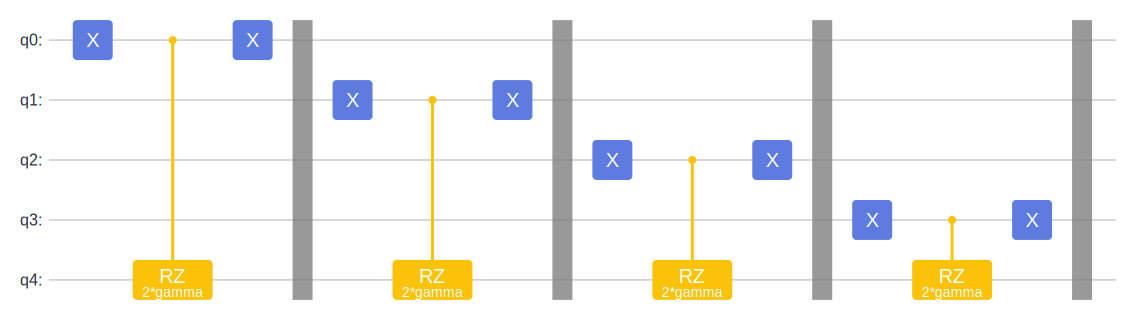

In [6]:
def build_D_part(para):

    qc_d = Circuit()

    for i in range(0, len(G.nodes)):
        qc_d += X.on(i)
        qc_d += RZ({para:2}).on(len(G.nodes), i)
        qc_d += X.on(i)
        qc_d.barrier()
    
    return qc_d

# Showing the constructed quantum circuit part
Di_circuit = build_D_part('gamma')
Di_circuit.svg()

# Build the quantum circuit of T_{i}(x)

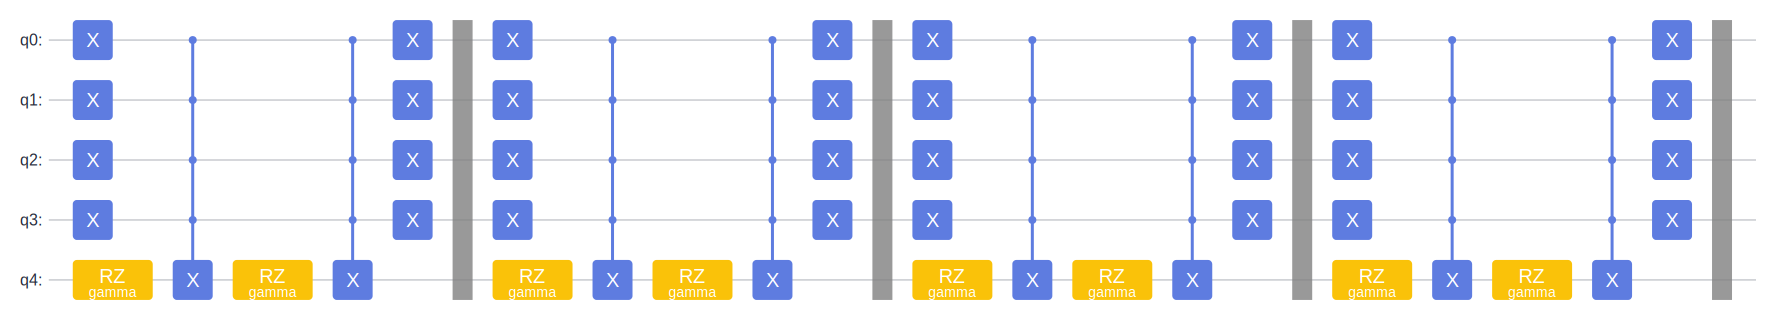

In [7]:
# The main components of quantum circuits with predefined T_{i}

def create_cor(ctrl_qubits, target_qubits, para):
    
    circuit = Circuit()
    
    for i in ctrl_qubits:
        circuit += X.on(i)
    
    circuit += RZ({para:1}).on(target_qubits)  
    circuit += X.on(target_qubits, ctrl_qubits)
    circuit += RZ({para:1}).on(target_qubits)  
    circuit += X.on(target_qubits, ctrl_qubits)
    
    for i in ctrl_qubits:
        circuit += X.on(i)
        
    return circuit


def build_T_part(para):            # para: parameter name
    
    target_qubits = len(G.nodes)   # The last qubit as the ancilla
    qc_t = Circuit()
    
    for node in range(0, len(G.nodes)):                                # For each node, construct a Multi_Controlled_OR quantum circuit
        neighbors = list(G.neighbors(node))  # Find the neighbors of the current node
        ctrl_qubits = [node] + neighbors                # The control qubits are the node and its neighbors
        
        qc_t += create_cor(ctrl_qubits, target_qubits, para)
        qc_t.barrier()
    
    return qc_t

# Showing the constructed quantum circuit part
Ti_circuit = build_T_part('gamma')
Ti_circuit.svg()

# Build the quantum circuit of the mixing Hamiltonian Hb

In [8]:
def build_hb():
    hb = QubitOperator()
    for i in range(len(G.nodes)):
        hb += QubitOperator('X{}'.format(i), 1)
    return hb

hb = build_hb()
print (hb)

1 [X0] +
1 [X1] +
1 [X2] +
1 [X3]


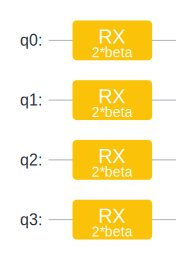

In [9]:
hb_circuit = TimeEvolution(hb,{'beta':1.0}).circuit
hb_circuit.svg()

# Total quantum circuit

In [10]:
def build_ansatz(p):        # p is the number of layers of ansatz                 
    circ = UN(H, len(G.nodes))
    circ.barrier()
    
    for i in range(p):
        # Add the quantum circuit corresponding to Uc, with parameters recorded as g0、g1、g2... 
        circ += build_D_part(f'gamma{i}')     
        circ += build_T_part(f'gamma{i}')   
        
        # Add the quantum circuit corresponding to Ub, with parameters recorded as b0, b1, b2...
        circ += TimeEvolution(hb,{f'beta{i}': 1.0}).circuit    
        circ.barrier()
    return circ

            Circuit Summary             
╭──────────────────────┬───────────────╮
│ Info                 │ value         │
├──────────────────────┼───────────────┤
│ Number of qubit      │ 5             │
├──────────────────────┼───────────────┤
│ Total number of gate │ 68            │
│ Barrier              │ 10            │
│ Noise Channel        │ 0             │
│ Measurement          │ 4             │
├──────────────────────┼───────────────┤
│ Parameter gate       │ 16            │
│ 2 ansatz parameters  │ gamma0, beta0 │
╰──────────────────────┴───────────────╯

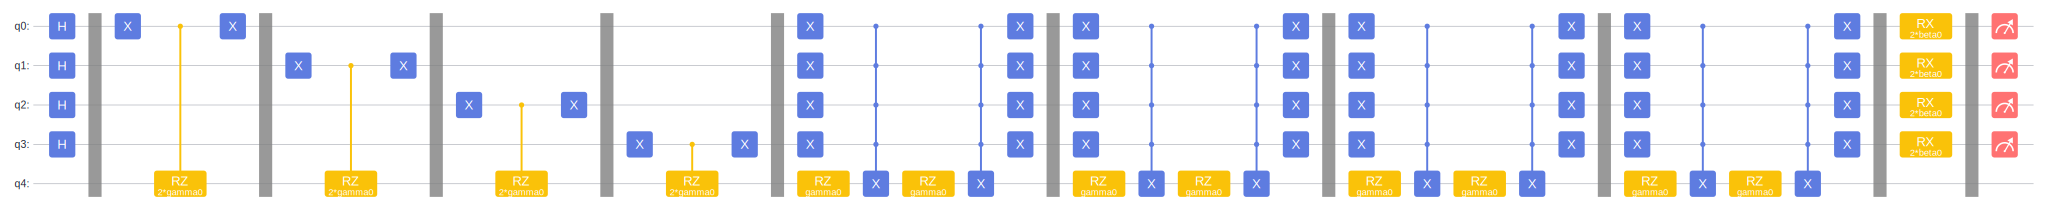

In [11]:
# To check the correctness of the quantum circuit and parameter names.

p = 1 
circ = build_ansatz(p)

# Add measurement gates
for node in G.nodes:
    circ += Measure().on(node)
    
circ.summary() 
circ.svg()

# Parameter training

In [12]:
p = 1                   # Set the number of ansatz layers of the quantum circuit
ham = Hamiltonian(H_C)    # Generate Hamiltonian
circ = build_ansatz(p)    # Build ansatz

ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")
sim = Simulator('mqvector', circ.n_qubits)                     # Create a simulator, backend uses 'mqvector'
grad_ops = sim.get_expectation_with_grad(ham, circ)            # Get operators that can compute the expected value and gradient
net = MQAnsatzOnlyLayer(grad_ops)                              # Generate a neural network to be trained. 

# Set the selection range of initial parameters
init_params = []
for name in circ.params_name:
    np.random.seed(42)                                     # Set a random seed here for easy reproduction
    if 'gamma' in name:
        init_params.append(np.random.rand() * 2 * np.pi)   # gamma∈(0, 2*pi)
    elif 'beta' in name:
        init_params.append(np.random.rand() * np.pi)       # beta∈(0, pi)
    else:
        raise ValueError(f"Unexpected parameter name: {name}")

init_params_weight = ms.Tensor(init_params, dtype=net.weight.dtype)
net.weight = Parameter(init_params_weight)
initial_parameters = dict(zip(circ.params_name, net.weight.asnumpy()))

opti = nn.Adam(net.trainable_params(), learning_rate = 0.05)    # Set the Adam optimizer with a learning rate of 0.05 for all trainable parameters
train_net = nn.TrainOneStepCell(net, opti)                      # Train the neural network for one step            


# #Train the neural network and calculate the results. Note: Each time 'train_net()' is run, the neural network is trained one step
for i in range(500):
    energy = train_net()    

    if i%10 ==0:
        print('i = %d, energy = %f'%(i,energy))

i = 0, energy = -5.449244
i = 10, energy = -5.750117
i = 20, energy = -5.744539
i = 30, energy = -5.751370
i = 40, energy = -5.750745
i = 50, energy = -5.753685
i = 60, energy = -5.765218
i = 70, energy = -5.831767
i = 80, energy = -5.887570
i = 90, energy = -5.881974
i = 100, energy = -5.889398
i = 110, energy = -5.889052
i = 120, energy = -5.889708
i = 130, energy = -5.889832
i = 140, energy = -5.889838
i = 150, energy = -5.889882
i = 160, energy = -5.889876
i = 170, energy = -5.889881
i = 180, energy = -5.889881
i = 190, energy = -5.889881
i = 200, energy = -5.889882
i = 210, energy = -5.889882
i = 220, energy = -5.889882
i = 230, energy = -5.889882
i = 240, energy = -5.889882
i = 250, energy = -5.889882
i = 260, energy = -5.889882
i = 270, energy = -5.889882
i = 280, energy = -5.889882
i = 290, energy = -5.889882
i = 300, energy = -5.889882
i = 310, energy = -5.889882
i = 320, energy = -5.889882
i = 330, energy = -5.889882
i = 340, energy = -5.889882
i = 350, energy = -5.889882
i =

In [13]:
def compute_total_probability(state, target_bitstrings, useful_qubits, total_qubits):
    """
    Compute the sum of marginal probabilities of multiple target bitstrings over the first useful_qubits qubits.
    
    parameter：
    - state: 2^n-dimensional complex vector, quantum state
    - target_bitstrings:  A list of target bitstrings, such as ["0010", "00100"] (low-endian to high-endian)
    - useful_qubits: Number of useful qubits k
    - total_qubits:  Total number of qubits n
    
    return：
    - The sum of marginal probabilities（fidelity with target subspace）
    """
    targets_set = set(bs[::-1] for bs in target_bitstrings)  # reverse bits for correct indexing
    prob = 0.0
    
    
    for i in range(2 ** total_qubits):
        b = format(i, f'0{total_qubits}b')  
        useful_part = b[-useful_qubits:]
        
        if useful_part in targets_set:
            prob += np.abs(state[i]) ** 2
            #print("Marginal probability obtained by trace out auxiliary qubits:", np.abs(state[i]) ** 2)
            
    return prob

total_qubits = circ.n_qubits
useful_qubits = len(G.nodes())
target_bitstrings = ["1000","0100","0010","0001"]    # low-endian to high-endian, obtained from solutions obtained by classical methods.
targets_set = set(bs[::-1] for bs in target_bitstrings)  # reverse bits for correct indexing

print("The number of total_qubits is:", total_qubits)
print("The number of useful_qubits is:", useful_qubits)
print("targets_set is:", targets_set)

The number of total_qubits is: 5
The number of useful_qubits is: 4
targets_set is: {'1000', '0001', '0100', '0010'}


In [14]:
pr = dict(zip(circ.params_name, net.weight.asnumpy()))   # Obtain quantum circuit parameters
state = circ.get_qs(pr = pr)                             # Get the final state of the quantum circuit after parameter training


probability = compute_total_probability(state, target_bitstrings, useful_qubits, total_qubits)
print("Total marginal probability:", probability)

# print('initial parameter is: {}'.format(initial_parameters))          # initial parameters
# print(('optimal parameter: {}'.format(pr)))                           # optimal parameters after training
# print('The F value is: {}'.format(energy))                            # The objective function value after parameter optimization (minimization)

Total marginal probability: 0.3700395177411573


In [15]:
def counts(state, useful_qubits):
    
    amp = np.abs(state) ** 2
    total_qubits = int(np.log2(len(amp)))
    counts = {}

    # Calculating marginal probabilities
    for i in range(len(amp)):
        b = format(i, f'0{total_qubits}b')     # n-bit binary string
        useful_part = b[-useful_qubits:]       # Take the last k bits (the low bit is on the right)
        counts[useful_part] = counts.get(useful_part, 0) + amp[i]
    
    
    return counts

bitstring_probs = counts(state, useful_qubits)
print('counts={}'.format(bitstring_probs))

counts={'0000': 0.15749018724371927, '0001': 0.0925098794352893, '0010': 0.09250987943528932, '0011': 0.0543403874419678, '0100': 0.09250987943528936, '0101': 0.0543403874419678, '0110': 0.054340387441967786, '0111': 0.03191959307879844, '1000': 0.09250987943528932, '1001': 0.054340387441967786, '1010': 0.054340387441967786, '1011': 0.03191959307879844, '1100': 0.05434038744196777, '1101': 0.03191959307879844, '1110': 0.03191959307879844, '1111': 0.01874959804812315}


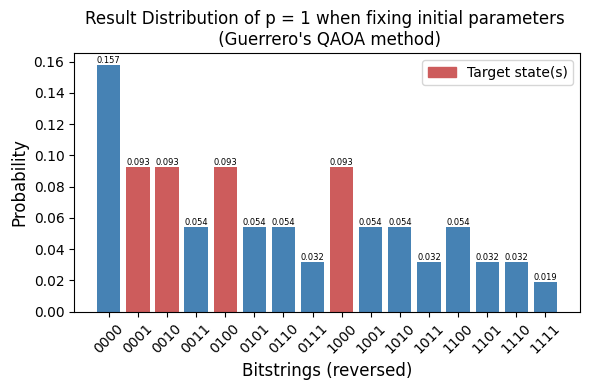

In [16]:
def show_useful_amp(state, useful_qubits, highlights=None):
    """
    Shows the marginal probability distribution of the first useful_qubits qubits, with the ability to highlight multiple target bitstrings.

    Parameters：
    - state: quantum state vector（complex）
    - useful_qubits: Number of useful qubits
    - highlights: list[str]，the target state to highlighted, which can be None
    """
    amp = np.abs(state) ** 2
    total_qubits = int(np.log2(len(amp)))
    counts = {}

    # Calculating marginal probabilities
    for i in range(len(amp)):
        b = format(i, f'0{total_qubits}b')     # n-bit binary string
        useful_part = b[-useful_qubits:]       # Take the last k bits (the low bit is on the right)
        counts[useful_part] = counts.get(useful_part, 0) + amp[i]

    # Preparing plot data
    labels = sorted(counts.keys())
    values = [counts[k] for k in labels]
    highlights = set(highlights or [])  

    # Highlight color setting : red is the target state, others are blue
    colors = ['IndianRed' if lbl in highlights else 'SteelBlue' for lbl in labels]

    # Plotting
    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, values, color=colors)
    plt.xticks(rotation=45)
    plt.title(f"Result Distribution of p = 1 when fixing initial parameters \n (Guerrero's QAOA method)")
    plt.xlabel(f"Bitstrings (reversed)", fontsize= 12)
    plt.ylabel(f"Probability", fontsize= 12)

    for bar, prob in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{prob:.3f}', ha='center', va='bottom', fontsize=6)

    if highlights:
        red_patch = plt.Rectangle((0,0),1,1,fc='IndianRed', edgecolor='IndianRed')
        plt.legend([red_patch], ['Target state(s)'], loc= 0)

    #plt.savefig("Guerrero's QAOA method.pdf", bbox_inches='tight', dpi=300)
    plt.tight_layout()
    plt.show()
    
    
# Convert the set displayed in targets_set to list type
target_states = list(targets_set)         #  bitstrings is reversed

# draw image
show_useful_amp(state, useful_qubits= len(G.nodes()), highlights=target_states)


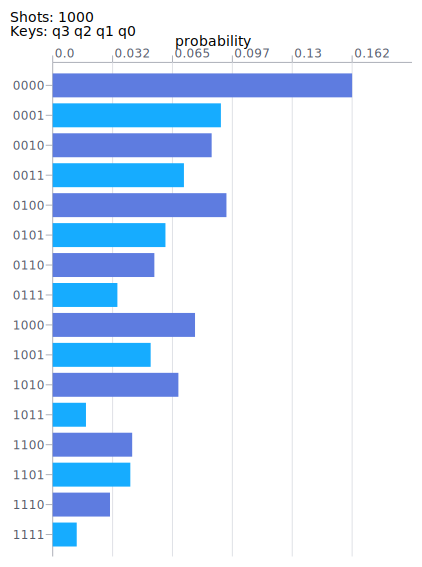

In [17]:
# Display the results obtained by the QAOA method

circ += UN(Measure(), len(G.nodes()))              # Add measurement gates 
result = sim.sampling(circ, pr=pr, shots=1000)      # Sampling the quantum circuit circuit2 1000 times by the simulator
result.svg()                                        # print sampling results

# Train QAOA ansatz multiple times with different initialization parameters

In [18]:
if __name__ == "__main__":
    
    results = []          # Create an empty DataFrame to store the results

    for p in range(1, 9):
        print('The p value is: {}'.format(p))
        
        for t in range(1, 201):
            ham = Hamiltonian(H_C)      # Generate Hamiltonian
            circ = build_ansatz(p)      # Generate ansatz

            ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")
            sim = Simulator('mqvector', circ.n_qubits)                           # Create a simulator, backend uses 'mqvector'
            grad_ops = sim.get_expectation_with_grad(ham, circ)                  # Get operators that can compute the expected value and gradient
            net = MQAnsatzOnlyLayer(grad_ops)                                    # Generate a neural network to be trained
            
            # Set the selection range of initial parameters
            init_params = []
            for name in circ.params_name:
                if 'gamma' in name:
                    init_params.append(np.random.rand() * 2 * np.pi)   # gamma∈(0, 2*pi)
                elif 'beta' in name:
                    init_params.append(np.random.rand() * np.pi)       # beta∈(0, pi)
                else:
                    raise ValueError(f"Unexpected parameter name: {name}")
            
            init_params_weight = ms.Tensor(init_params, dtype=net.weight.dtype)
            net.weight = Parameter(init_params_weight)
            initial_parameters = dict(zip(circ.params_name, net.weight.asnumpy()))
                        
            opti = nn.Adam(net.trainable_params(), learning_rate = 0.05)    # Set the Adam optimizer with a learning rate of 0.05 for all trainable parameters
            train_net = nn.TrainOneStepCell(net, opti)                      # Train the neural network for one step                     
                
            # Train the neural network and calculate the results.
            for i in range(500):
                energy = train_net()
                
                
            pr = dict(zip(circ.params_name, net.weight.asnumpy()))                # Obtain quantum circuit parameters
            state = circ.get_qs(pr=pr)                                            # Get the final state of the quantum circuit after parameter training
            
            bitstring_probs = counts(state, useful_qubits)
            probability = compute_total_probability(state, target_bitstrings, useful_qubits, total_qubits)
            
            
            # Here, probability represents the probability of obtaining the correct solution to the MDS problem on the graph. 
            # If the MDS problem has multiple optimal solutions, this probability represents the sum of all the optimal solutions.

            # Add training results to the list
            results.append({"p": p, "t": t, "probability": probability, **bitstring_probs})

        # Convert the list to DataFrame
        df = pd.DataFrame(results)

        # Writing DataFrame to Excel File
        df.to_excel(r"/home/lzztlb/liguanghui/AAResearch/liguanghui（code)/Research/New QAOA for MDS/paper/4-vertex 3-regular graph/data/Guerrero's QAOA method (RG4-3).xlsx", index=False)

The p value is: 1
The p value is: 2
The p value is: 3
The p value is: 4
The p value is: 5
The p value is: 6
The p value is: 7
The p value is: 8


# Plot the average probability of different bitstrings at circuit layer p

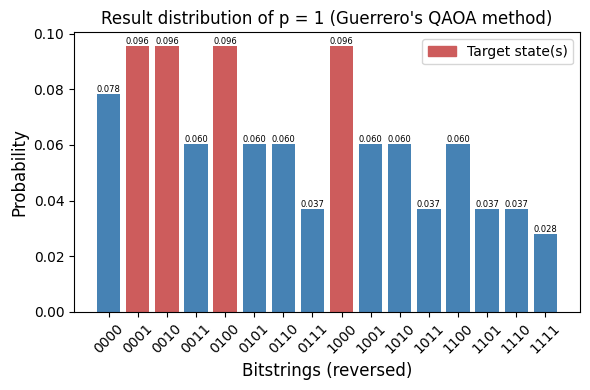

In [1]:
import matplotlib.pyplot as plt

def show_useful_amp(useful_qubits, highlights=None):
    """
    Shows the marginal probability distribution of the first useful_qubits qubits, with the ability to highlight multiple target bitstrings.

    Parameters：
    - useful_qubits: Number of useful qubits
    - highlights: list[str]，the target state to highlighted, which can be None
    """

    # Preparing plot data
    labels = sorted(counts.keys())
    values = [counts[k] for k in labels]
    highlights = set(highlights or [])  

    # Highlight color setting : red is the target state, others are blue
    colors = ['IndianRed' if lbl in highlights else 'SteelBlue' for lbl in labels]

    # Plotting
    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, values, color=colors)
    plt.xticks(rotation=45)
    plt.title(f"Result distribution of p = 1 (Guerrero's QAOA method)")
    plt.xlabel(f"Bitstrings (reversed)", fontsize= 12)
    plt.ylabel(f"Probability", fontsize= 12)

    for bar, prob in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{prob:.3f}', ha='center', va='bottom', fontsize=6)

    if highlights:
        red_patch = plt.Rectangle((0,0),1,1,fc='IndianRed', edgecolor='IndianRed')
        plt.legend([red_patch], ['Target state(s)'], loc = 0)

    plt.savefig("Result distribution of p = 1 (Guerrero's QAOA method RG4-3).pdf", bbox_inches='tight', dpi=300)
    plt.tight_layout()
    plt.show()
    

    
# The average counts calculated based on the above results
counts = {'0000': 0.078396427
, '0001': 0.095732417
, '0010': 0.095732417
, '0011': 0.060489028
, '0100': 0.095732417
, '0101': 0.060489028
, '0110': 0.060489028
, '0111': 0.036903958
, '1000': 0.095732417
, '1001': 0.060489028
, '1010': 0.060489028
, '1011': 0.036903958
, '1100': 0.060489028
, '1101': 0.036903958
, '1110': 0.036903958
, '1111': 0.028123902
}


target_bitstrings = ["1000","0100","0010","0001"]         # low-endian to high-endian, obtained from solutions obtained by classical methods.
targets_set = set(bs[::-1] for bs in target_bitstrings)  # reverse bits for correct indexing

# Convert the set displayed in targets_set to list type
target_states = list(targets_set)         #  bitstrings is reversed

# draw image
show_useful_amp(useful_qubits= 4, highlights=target_states)
